In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import *
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as tf
import os
from torch.optim import RMSprop
from torchvision.utils import make_grid
from pylab import plt

In [5]:
#基本配置
path=os.path.abspath('../../dataset/Animals_with_Attributes2/')
num_chann=np.array([64*8,64*4,64*2,64,64])
dnum_chann=np.array([64,64*2,64*4,64*8])
img_size=64
noise_size=100
im_chann=3
bat_size=32
tr_epoch=6
worker=1
gpu=True
clamp_num=0.01
learningr=0.005

transform1=transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3,[0.5]*3)
])

In [6]:
class ZSLdata(Dataset):
    def __init__(self,root,transforms,train_data=True):
        if train_data==True:
            #root_label=os.path.abspath('../dataset/Animals_with_Attributes2')
            label_path=[x.path for x in os.scandir(root) if 'train' in x.path]
            word=[]
            for i,file_label in enumerate(label_path):
                f=open(file_label,'r')
                while True:
                    temp_w=f.readline().strip()
                    if not temp_w:
                        break
                    word.append(temp_w)
                f.close()
            
            path_dir=[]
            self.label_list=word
            for key_word in self.label_list:
                [path_dir.append(x.path) for x in os.scandir(root+'/JPEGImages/') if x.name.endswith(key_word)]
                
            pic_path=[]
            for train_root in path_dir:#对训练集文件夹遍历
                [pic_path.append(x.path) for x in os.scandir(train_root) if x.name.endswith(".jpg")]#每个文件夹里的图片地址
            #pic_path=path_dir#图片文件夹目录
            self.images_files=pic_path #图片目录
            self.transforms=transforms
            
        else:
            self.path#测试机读取
        
    def __getitem__(self,index):
        try:
            pic_data=self.transforms(Image.open(self.images_files[index]))
            
        except RuntimeError:
            print(self.images_files[index])
            return self.transforms(Image.open(self.images_files[index-1]))
            
        else:
            return pic_data
        
        
        #return self.transforms(Image.open(self.images_files[index]))
    
    def __len__(self):
        return len(self.images_files)

In [7]:
generator=nn.Sequential(
    nn.ConvTranspose2d(noise_size,num_chann[0],4,1,0,bias=False),
    nn.BatchNorm2d(num_chann[0]),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(num_chann[0],num_chann[1],4,2,1,bias=False),
    nn.BatchNorm2d(num_chann[1]),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(num_chann[1],num_chann[2],4,2,1,bias=False),
    nn.BatchNorm2d(num_chann[2]),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(num_chann[2],num_chann[3],4,2,1,bias=False),
    nn.BatchNorm2d(num_chann[3]),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(num_chann[3],im_chann,4,2,1,bias=False),
    nn.Tanh()

)

discriminator=nn.Sequential(
                             nn.Conv2d(im_chann,dnum_chann[0],4,2,1,bias=False),
                             nn.LeakyReLU(0.2,inplace=True),
                             
                             nn.Conv2d(dnum_chann[0],dnum_chann[1],4,2,1,bias=False),
                             nn.BatchNorm2d(dnum_chann[1]),
                             nn.LeakyReLU(0.2,inplace=True),
                             
                             nn.Conv2d(dnum_chann[1],dnum_chann[2],4,2,1,bias=False),
                             nn.BatchNorm2d(dnum_chann[2]),
                             nn.LeakyReLU(0.2,inplace=True),
                             
                             nn.Conv2d(dnum_chann[2],dnum_chann[3],4,2,1,bias=False),
                             nn.BatchNorm2d(dnum_chann[3]),
                             nn.LeakyReLU(0.2,inplace=True),
                             
                             nn.Conv2d(dnum_chann[3],1,4,1,0,bias=False)
                            )
    
def weight_init(m):
    # weight_initialization: important for wgan
    class_name=m.__class__.__name__
    if class_name.find('Conv')!=-1:
        m.weight.data.normal_(0,0.02)
    elif class_name.find('Norm')!=-1:
        m.weight.data.normal_(1.0,0.02)
        
        
discriminator.apply(weight_init)
generator.apply(weight_init)
optimizerD = RMSprop(discriminator.parameters(),lr=learningr) 
optimizerG = RMSprop(generator.parameters(),lr=learningr) 


200
400
600
800
/home/zhaozhi/dataset/Animals_with_Attributes2/JPEGImages/collie/collie_10718.jpg


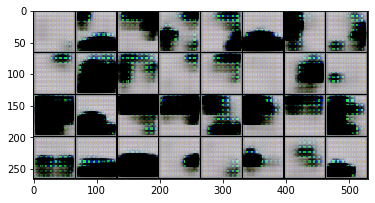

200
400
600
800
/home/zhaozhi/dataset/Animals_with_Attributes2/JPEGImages/collie/collie_10718.jpg


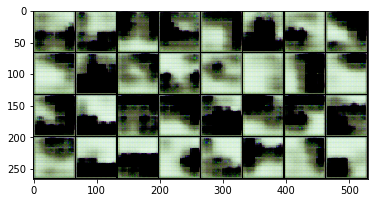

200
400
600
800
/home/zhaozhi/dataset/Animals_with_Attributes2/JPEGImages/collie/collie_10718.jpg


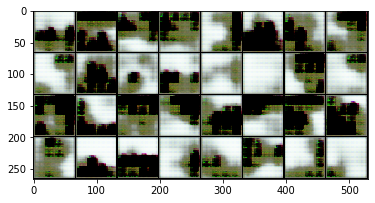

200
400
600
800
/home/zhaozhi/dataset/Animals_with_Attributes2/JPEGImages/collie/collie_10718.jpg


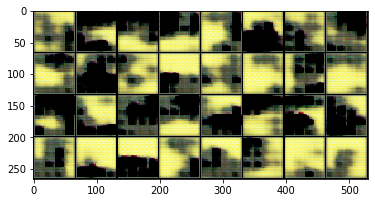

200
400
600
800
/home/zhaozhi/dataset/Animals_with_Attributes2/JPEGImages/collie/collie_10718.jpg


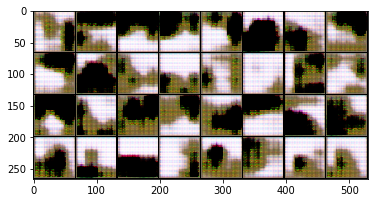

200
400
600
800
/home/zhaozhi/dataset/Animals_with_Attributes2/JPEGImages/collie/collie_10718.jpg


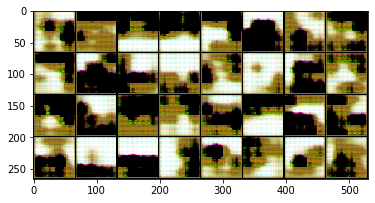

In [8]:
#训练准备
fix_noise=torch.randn(bat_size,noise_size,1,1)
dataset=ZSLdata(path,transform1,train_data=True)
data_trainer=DataLoader(dataset,bat_size,shuffle = True,num_workers=worker)
if gpu:
    fix_noise=fix_noise.cuda()
    generator.cuda()
    discriminator.cuda()
    
one=torch.ones([1],dtype=torch.float)
mione=one*-1


for epoch in range(tr_epoch):
    for i,data in enumerate(data_trainer,0):
        if (i+1)%200==0:
            print(i+1)
        #print(i+1)
        #data=data_all[0]
        #if i>885:
            #print(data_all[1])
        input=data
        noise = torch.randn(input.size(0),noise_size,1,1)
        
        if gpu:
            one=one.cuda()
            mione=mione.cuda()
            input=input.cuda()
            noise=noise.cuda()
            
        for para in discriminator.parameters():
            para.data.clamp_(-clamp_num,clamp_num)
            
        discriminator.zero_grad()
        ## train netd with real img
        output=discriminator(input).mean().view(1)
        #output.backward()
        ## train netd with fake img
        fake_pic=generator(noise).detach()
        output2=discriminator(fake_pic).mean().view(1)
        output2=output-output2
        output2.backward()
        optimizerD.step()
        
        if (i+1)%5 ==0:
            generator.zero_grad()
            noise.data.normal_(0,1)
            fake_pic=generator(noise)
            output=discriminator(fake_pic).mean().view(1)
            output.backward()
            optimizerG.step()
            if i%100==0:pass
    fake_u=generator(fix_noise)
    imgs = make_grid(fake_u.data*0.5+0.5).cpu() # CHW
    plt.imshow(imgs.permute(1,2,0).numpy()) # HWC
    outprint=tf.to_pil_image(imgs)
    outprint.save('./results/'+str(epoch)+'th epoch result.png')
    plt.show()